Three end-member linear mixing model analysis of oak water source

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from scipy.optimize import nnls

import os
import statsmodels.api as sm
from matplotlib import cm
import matplotlib.cm as cmx
import matplotlib.colors as colors
import matplotlib.dates as mdates
plt.rcParams["font.sans-serif"] = "Arial"
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

plt.rcParams['figure.autolayout'] = True

plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['mathtext.rm'] = 'Helvetica'
plt.rcParams['mathtext.it'] = 'Helvetica:italic'
plt.rcParams['mathtext.bf'] = 'Helvetica:bold'
plt.rcParams['font.size'] = 10

import matplotlib as mpl
%matplotlib inline


In [2]:
df = pd.read_csv('../Data/isotope-data.csv',
                 sep=',',  skiprows = [1])
df['Time Collected'] = df['Time Collected'].fillna('12:00')
df['datetime'] = pd.to_datetime(df['Date Collected']+ ' ' + df['Time Collected'])

#Read in sapflow data
sapflow = pd.read_csv('../Data/sapflow_2016_cumulative_normalized.csv',header=None)
sapflow.columns=['date','Cumulative normalized sapflow']
sapflow.index = pd.to_datetime(sapflow.date)


In [3]:
# BULK SUBSURFACE SAMPLES


drilled = df[(df['Sample Type II']=='Drilled material')]
drilled['Depth (cm)'] = drilled['Depth (cm)'].astype(float)
soil = drilled[drilled['Sample Type III'] =='Soil'] 
sap_wxbedrock = drilled[(drilled['Sample Type III'] =='Saprolite') | 
                        (drilled['Sample Type III'] =='Weathered bedrock')] 

sagehorn = df[df['Site']=='Sagehorn']

sagehornOaks = sagehorn[sagehorn['Species (scientific)']=='QUGA']

startDateTime = pd.to_datetime('2015-01-01 00:00:00')

sagehornOaks2016 = sagehornOaks[sagehornOaks['datetime'] > startDateTime] 
stems = sagehornOaks2016[sagehornOaks2016['Sample Type II']=='Stem']
stems = stems[stems.Location!='T210']

sagehornGW = sagehorn[sagehorn['Sample Type II'] == 'Well water']
sagehornGW['Location'].replace(to_replace='MN-1', value='MN1', inplace=True)
sagehornGW['Location'].replace(to_replace='MS-4', value='MS4', inplace=True)


sagehornGW = sagehornGW[(sagehornGW['Location'] == 'MN1') | 
                      (sagehornGW['Location'] == 'MN-1') |
                      (sagehornGW['Location'] == 'MS4') |
                      (sagehornGW['Location'] == 'MS-4')|
                      (sagehornGW['Location'] == 'W507')]
stems = stems.sort_values('datetime')
stems = stems[stems.Location != 'T87']
trees = sorted(set((stems['Location'])))
sagehornGW = sagehornGW.sort_values('datetime')
wells = sorted(set((sagehornGW['Location'])))


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:6586: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [4]:

# toggle to use non-negative regression
use_nonnegative = True

dfs = []
for well in wells:
    plotData = sagehornGW[sagehornGW['Location']==well]
    plotData = plotData.sort_values('datetime')
    temp = plotData[['datetime', 'dD', 'dO']].copy()
    temp = temp.set_index('datetime')
    temp = temp.resample('D').mean()
    start = temp.index.values[0]
    stop = temp.index.values[-1]
    idx = pd.date_range('5-15-2016', '10-2016')
    temp = temp.loc[idx].interpolate()
    dfs.append(temp)   
pole_gw = pd.concat(dfs).groupby(level=0).mean()

dfs = []
for tree in trees:
    plotData = stems[stems['Location']==tree]
    temp = plotData[['datetime', 'dD', 'dO']].copy()
    temp = temp.set_index('datetime')
    temp = temp.resample('D').mean()
    start = temp.index.values[0]
    stop = temp.index.values[-1]
    idx = pd.date_range('5-15-2016', '10-2016')
    temp = temp.loc[idx].interpolate()
    dfs.append(temp)
pole_trees = pd.concat(dfs).groupby(level=0).mean()

temp = soil[['datetime', 'dD', 'dO']].copy()
temp = temp.set_index('datetime')
temp = temp.resample('D').mean()
start = temp.index.values[0]
stop = temp.index.values[-1]
idx = pd.date_range('5-15-2016', '10-2016')
temp = temp.loc[idx].interpolate()
pole_soils = temp.copy()

temp = sap_wxbedrock[['datetime', 'dD', 'dO']].copy()
temp = temp.set_index('datetime')
temp = temp.resample('D').mean()
start = temp.index.values[0]
stop = temp.index.values[-1]
idx = pd.date_range('5-15-2016', '9-18-2016')
temp = temp.loc[idx].interpolate()
pole_wx = temp.copy()

idx = pole_soils.loc[np.isfinite(pole_soils.dD)&np.isfinite(pole_soils.dO)].index.values
pole_soils, pole_gw, pole_wx, pole_trees = pole_soils.loc[idx], pole_gw.loc[idx], pole_wx.loc[idx], pole_trees.loc[idx]

emma_df = pd.DataFrame()
for day in pole_trees.index.values:
    soilvec = pole_soils[['dD', 'dO']].loc[day].values
    wxvec =  pole_wx[['dD', 'dO']].loc[day].values
    gwvec = pole_gw[['dD', 'dO']].loc[day].values
    treevec = pole_trees[['dD', 'dO']].loc[day].values
    
    if np.isnan(np.sum(wxvec)):
        continue
    
    lhs = np.hstack([treevec, [1.0]])
    A = np.array([[soilvec[0], wxvec[0], gwvec[0]],[soilvec[1], wxvec[1], gwvec[1]],[1,1,1]])
    Ainv = np.linalg.inv(A)
    if use_nonnegative:
        fracs = nnls(A,lhs)[0]
    else: 
        fracs = np.dot(Ainv, lhs)
    temp = pd.DataFrame({'Soil fraction':fracs[0], 'Wx fraction':fracs[1], 'GW fraction':fracs[2]},index=[day])
    emma_df = emma_df.append(temp)
    
    
emma_df.head()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:51: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


,Soil fraction,Wx fraction,GW fraction
2016-06-11,0.685882,0.201996,0.112122
2016-06-12,0.669571,0.217786,0.112643
2016-06-13,0.653781,0.233060,0.113159
2016-06-14,0.638485,0.247844,0.113671
2016-06-15,0.623661,0.262160,0.114179


In [6]:
sapflow_daily = sapflow.resample('D').mean()
sapflow_diff = sapflow_daily.diff()

In [7]:
merged = emma_df.merge(sapflow_diff,how='left',left_index=True,right_index=True)
merged['Cumulative normalized sapflow'] = merged['Cumulative normalized sapflow'] * (1.0/merged['Cumulative normalized sapflow'].sum())
merged.head()

,Soil fraction,Wx fraction,GW fraction,Cumulative normalized sapflow
2016-06-11,0.685882,0.201996,0.112122,0.010382
2016-06-12,0.669571,0.217786,0.112643,0.011321
2016-06-13,0.653781,0.233060,0.113159,0.011137
2016-06-14,0.638485,0.247844,0.113671,0.009772
2016-06-15,0.623661,0.262160,0.114179,0.008489


/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


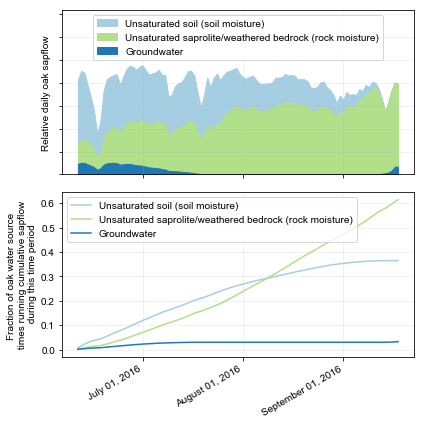

In [17]:
fig,ax = plt.subplots(nrows=2,ncols=1,sharex=True,figsize=(6,6),)
ax[0].fill_between(emma_df.index,
                y1=merged['Cumulative normalized sapflow']-emma_df['Soil fraction']*merged['Cumulative normalized sapflow'],
                y2=merged['Cumulative normalized sapflow'],
                color='#a6cee3',
                alpha=1,
                label='Unsaturated soil (soil moisture)')


ax[0].fill_between(emma_df.index,
                y1=emma_df['GW fraction']*merged['Cumulative normalized sapflow'],
                y2=merged['Cumulative normalized sapflow']-emma_df['Soil fraction']*merged['Cumulative normalized sapflow'],
                color='#b2df8a',alpha=1,label='Unsaturated saprolite/weathered bedrock (rock moisture)')

ax[0].fill_between(emma_df.index,
                y1=0,
                y2=emma_df['GW fraction']*merged['Cumulative normalized sapflow'],
                color='#1f78b4',alpha=1,label='Groundwater')

ax[0].legend(loc='upper center',fontsize=10)
ax[0].set_ylabel('Relative daily oak sapflow',fontsize=10)
ax[0].grid(alpha=.2)
ax[0].set_ylim(0,.018)


#
ax[1].plot((merged['Cumulative normalized sapflow']*merged['Soil fraction']).cumsum(),
          color='#a6cee3',
                alpha=1,
                label='Unsaturated soil (soil moisture)')
ax[1].plot((merged['Cumulative normalized sapflow']*merged['Wx fraction']).cumsum(),
          color='#b2df8a',alpha=1,label='Unsaturated saprolite/weathered bedrock (rock moisture)')
ax[1].plot((merged['Cumulative normalized sapflow']*merged['GW fraction']).cumsum(),
                color='#1f78b4',alpha=1,label='Groundwater')
ax[1].legend(loc='upper left')

ax[1].set_ylabel('Fraction of oak water source \n times running cumulative sapflow \n during this time period',fontsize=10)
ax[1].grid(alpha=.2)


months = mdates.MonthLocator()  # every month
ax[1].xaxis.set_major_locator(months)

month_fmt = mdates.DateFormatter('%B %d, %Y')
ax[1].xaxis.set_major_formatter(month_fmt)

ax[0].set_yticklabels([])
fig.autofmt_xdate()

plt.savefig('../Figs/emma.pdf')